
# CNN and SVM model simplified 
Extension of "model_and_features_eval" but a version that is faster to run multiple times 

### Import stuff

In [3]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from functions import *
from possible_data_to_extract import *
from constants import *


# Things to choose: 

In [4]:
###########################################
# Seed number 
seed_number = 42
np.random.seed(seed_number) 

# DEFINE FEATURE GROUPS
#features_to_plot_names = articulation_all_features + phonation_all_features + prosody_all_features, articulation_all_features, phonation_all_features, prosody_all_features, SoAf_all_mean
#names = ["all","articulation_all_features", "phonation_all_features", "prosody_all_features", "SoAf_all_mean"]
features_to_plot_names = [phonation_all_features] #  [["avg Shimmer", "avg Jitter", "avg ppq", "avg apq","std Shimmer", "std Jitter", "std ppq", "std apq","kurtosis Shimmer", "kurtosis Jitter", "kurtosis ppq", "kurtosis apq", "skewness Shimmer", "skewness Jitter", "skewness ppq", "skewness apq"]]
names = ["Test"]

# Utterances 
hc_paths = hc_paths_vowels + hc_paths_mod_vowels
pd_paths = pd_paths_vowels + pd_paths_mod_vowels

data_types = [""] # Example: ["/A", "viaje"]  

###########################################

# Extracting data: 

In [5]:
# Add inn all features 
choosen_features = {}
choosen_features["Articulation"] =  articulation_all_features
choosen_features["Phonation"] =  phonation_all_features
choosen_features["Prosody"] =  prosody_all_features

choosen_features["Articulation"].append('id') 


base_path = "PC-GITA-static-features" 
hc_paths = extend_paths(hc_paths, base_path)
pd_paths = extend_paths(pd_paths, base_path)

hc_paths = find_certain_paths_from_all_paths(hc_paths, data_types)
pd_paths = find_certain_paths_from_all_paths(pd_paths, data_types)

features = {}
features["HC"] = get_features(hc_paths, choosen_features)
features["PD"] = get_features(pd_paths, choosen_features)


metadata_path = os.path.join(personal_path_to_PC_GITA,'PCGITA_metadata.xlsx')
metadata = pd.read_excel(metadata_path)

metadata_columns = ["SEX", "AGE", "UPDRS", "UPDRS-speech", "H/Y", "time after diagnosis"]

features["HC"] = add_metadata_columns(features["HC"], metadata, metadata_columns)
features["PD"] = add_metadata_columns(features["PD"], metadata, metadata_columns)

metadata_columns.append("id") 

features_male = {}
features_female =  {}

for key in features.keys(): 
    features_male[key] = features[key][features[key]['SEX'] == 'M']
    features_female[key] = features[key][features[key]['SEX'] == 'F']

# Restructure data 

# SVM - Model based on best result from the grid search 

FEATURE: ----------------------------- Test
Adjusterd the features
['avg DF0', 'avg DDF0', 'avg Jitter', 'avg Shimmer', 'avg apq', 'avg ppq', 'avg logE', 'std DF0', 'std DDF0', 'std Jitter', 'std Shimmer', 'std apq', 'std ppq', 'std logE', 'skewness DF0', 'skewness DDF0', 'skewness Jitter', 'skewness Shimmer', 'skewness apq', 'skewness ppq', 'skewness logE', 'kurtosis DF0', 'kurtosis DDF0', 'kurtosis Jitter', 'kurtosis Shimmer', 'kurtosis apq', 'kurtosis ppq', 'kurtosis logE']
(2000, 28)
 
 --------------------------------------------  
Result from model using the best result from grid searchs
 
Training Accuracy: 67.58%
Test Accuracy: 65.50%
Sensitivity (Recall of PD): 62.75%
Specificity (Recall of HC): 68.25%
 
 --------------------------------------------  
Results over all 10 folds:
 
Accuracy over all 10 folds: [64.5, 69.5, 67.0, 71.0, 64.0, 59.0, 67.0, 65.5, 66.0, 66.0]
Average Accuracy: 66.0%
The accuracy is variating between 59.0% and 71.0%
The std of the accuracy: 3.1%
 
Sensi

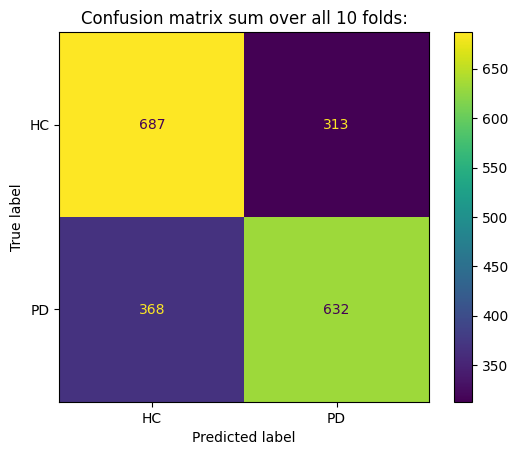

In [6]:

for i in range(len(names)): 
    print("FEATURE: -----------------------------", names[i])
    features_to_run = {}
    features_to_run["HC"] = features["HC"].copy()
    features_to_run["PD"] = features["PD"].copy()

    if features_to_plot_names:
        features_to_run["HC"] = features["HC"].loc[:, features_to_plot_names[i] + metadata_columns]
        features_to_run["PD"] = features["PD"].loc[:, features_to_plot_names[i] + metadata_columns]
        print("Adjusterd the features")
        print(features_to_plot_names[i])
        
    values = []
    labels = []
    metadata = [] 

    for label, value in features_to_run.items():
        metadata.extend(np.array(value[metadata_columns])) 
        value = np.array(value.drop(columns = metadata_columns))
        values.extend(value)  
        num_label = class_labels[label]
        labels.extend([num_label] * len(value)) 

    num_features = len(values[0])
    values = np.array(values).reshape(-1, num_features) 
    labels = np.array(labels) 
    metadata = np.array(metadata) 

    values = np.nan_to_num(values, nan=0)
    labels = np.nan_to_num(labels, nan=0)
    print(values.shape)


    train_data, test_data, train_labels, test_labels, train_metadata, test_metadata = train_test_split(values, labels, metadata, test_size=0.4, random_state=seed_number, stratify=labels)

    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)


    #################################
    kernel_best ='rbf' 
    C_best = 10
    gamma_best = 0.001
    #################################


    print(" ")
    print(" --------------------------------------------  ")
    print("Result from model using the best result from grid searchs")
    print(" ")
    svm_model = SVC(kernel=kernel_best, C=C_best, gamma=gamma_best, random_state=seed_number) # Only use gamma for the rbf kernel 
    svm_model.fit(train_data, train_labels)

    train_predictions = svm_model.predict(train_data)
    accuracy_train = accuracy_score(train_labels, train_predictions)
    print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

    test_predictions = svm_model.predict(test_data)
    accuracy_test = accuracy_score(test_labels, test_predictions)
    print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

    _ = sensitivity_and_specificity(y_true=test_labels, y_pred = test_predictions)

    print(" ")
    print(" --------------------------------------------  ")
    x_fold_cross_val(x=values, y=labels, model=svm_model, num_folds=10, random_state=seed_number, model_type ="SVM", write_out=False)